Layers A and B have the thicknesses  $d_A = 200 nm$  and  $d_B = 300 nm$ , and the dielectric constants $ϵ_A = 12$ and $ϵ_B = 3$. Compute and plot T vs ω for structure of 10 repeated AB followed by 10 repeated BA.(300 < ω < 600 THz)

### 參數設定

In [1]:
import numpy as np
#頻率相關參數
Nf = 500
fmin = 1
fmax = 2
fre = np.linspace(fmin, fmax, Nf)
fcen = (fmin+fmax)/2
df = (fmax-fmin)
omega = 2 * np.pi * fre

In [2]:
#結構重複次數
num_pairs = 10
#晶體厚度
d_single = [0.2, 0.3]
d_list = []
for i in range(num_pairs):
    for j in range(len(d_single)-1):
        d_list.append(d_single[0])
        d_list.append(d_single[1])
for i in range(num_pairs):
    for j in range(len(d_single)-1):
        d_list.append(d_single[1])
        d_list.append(d_single[0])
d = sum(d_list)
d_pair = sum(d_single)
#材料介電常數
epsi_single = [12, 3]
epsi_list = []
for i in range(num_pairs):
    for j in range(len(epsi_single)-1):
        epsi_list.append(epsi_single[0])
        epsi_list.append(epsi_single[1])
for i in range(num_pairs):
    for j in range(len(epsi_single)-1):
        epsi_list.append(epsi_single[1])
        epsi_list.append(epsi_single[0])

In [3]:
#材料相位差
delta_list = []
for o in omega:
    delta_each_o = []
    for epsi, a in zip(epsi_list, d_list):
        delta = 2 * o * a * np.sqrt(epsi)
        delta_each_o.append(delta)
    delta_list.append(delta_each_o)
delta_array = np.array(delta_list)

In [4]:
epsi_all = epsi_list.copy()  
epsi_all.insert(0, 1)
epsi_all.append(1)

### 轉移矩陣數值分析

In [5]:
#介面反射係數
r_list = []
for i in range(len(epsi_all)-1):
    r = (np.sqrt(epsi_all[i]) - np.sqrt(epsi_all[i+1])) / \
        (np.sqrt(epsi_all[i]) + np.sqrt(epsi_all[i+1]))
    r_list.append(r)
r_array = np.array(r_list)
#介面透射係數
t_list = []
for i in range(len(epsi_all)-1):
    t = 2 * (np.sqrt(epsi_all[i])) / \
        (np.sqrt(epsi_all[i]) + np.sqrt(epsi_all[i+1]))
    t_list.append(t)
t_array = np.array(t_list)

In [6]:
#介面反透射矩陣
i = 1j
D_list = []
for idx, t in enumerate(t_array):
    r_num = r_array[idx]
    D = (1 / t) * np.array([[1, r_num],
                            [r_num, 1]])
    D_list.append(D)
D_array = np.array(D_list)

In [7]:
#材料傳遞矩陣
P_list = []
for deltas in delta_array:
    P_temp = []
    for delta in deltas:
        P_11 = np.exp(-i * delta * 0.5)
        P_22 = np.exp(i * delta * 0.5)
        P = np.array([[P_11, 0],
                      [0, P_22]])
        P_temp.append(P)
    P_list.append(P_temp)
P_array = np.array(P_list)

In [8]:
#轉換矩陣
M_end_per_freq = np.zeros((Nf, 2, 2), dtype=complex)
for idx in range(Nf):
    P_array_per_freq = P_array[idx]
    M_temp = np.eye(2, 2)
    for k in range(len(epsi_list)):
        M_temp = M_temp @ np.array(D_array[k])
        M_temp = M_temp @ np.array(P_array_per_freq[k])
    M_temp = M_temp @ np.array(D_array[-1])
    M_end_per_freq[idx] = M_temp

In [9]:
#反射與透射
R_array = np.array([])
T_array = np.array([])
for i in range(Nf):
    Er = M_end_per_freq[i,1,0] / M_end_per_freq[i,0,0]
    R = np.abs(Er**2)
    T = 1 - R
    R_array = np.append(R_array,R)
    T_array = np.append(T_array,T)
T_tmat = T_array.tolist()

### 散射矩陣數值分析

In [10]:
R_smat = []
T_smat = []
for M in M_end_per_freq:
    detM = M[0,0]*M[1,1] - M[0,1]*M[1,0]
    S11 = -M[1,0] / M[1,1]
    S21 = detM / M[1,1]
    R = np.abs(S11)**2
    T = np.abs(S21)**2
    R_smat.append(R)
    T_smat.append(T)
R_smat = np.array(R_smat)
T_smat = np.array(T_smat)

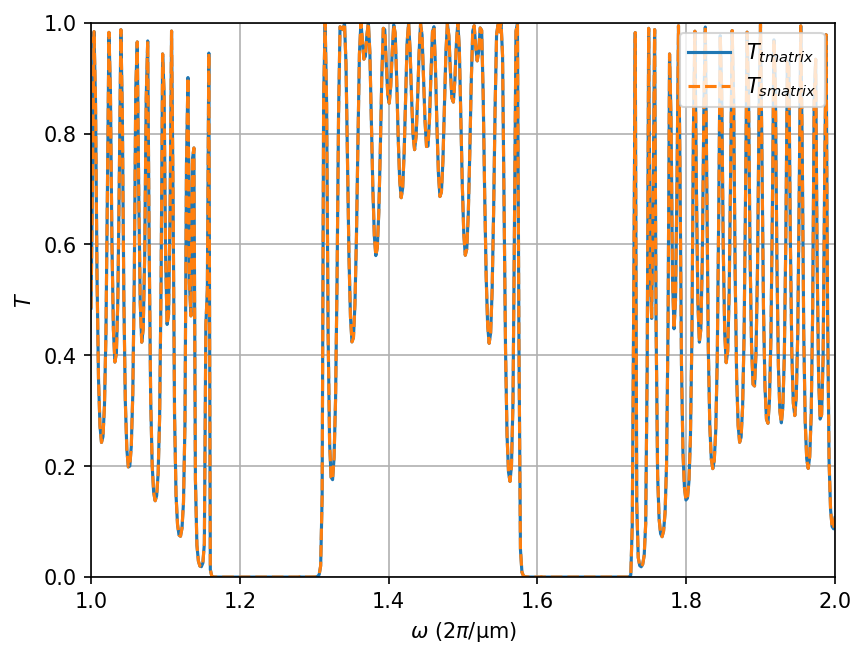

In [11]:
#繪圖比較(數值與實驗)
from matplotlib import pyplot as plt 
plt.figure(dpi=150)
plt.plot(omega/2/np.pi, T_tmat, label='$T_{tmatrix}$')
plt.plot(omega/2/np.pi, T_smat, '--', label='$T_{smatrix}$')
plt.xlabel("$\omega$ ($2\pi$/μm)")
plt.ylabel("$T$")
plt.legend(loc="upper right")
plt.xlim([1,2])
plt.ylim([0,1])
plt.grid()
plt.show()

### meep模擬

In [12]:
import meep as mp
#模擬空間參數
resolution = 500
dpml = 1.0
sz = (d_pair * 30.0) + (dpml * 2.0)
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]
dimensions = 1

In [13]:
#電磁波源(高斯)
sour_z = - (d / 2) - 0.3 
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, 
                     center=mp.Vector3(z=sour_z))]

In [14]:
#整體模擬流程(真空場)
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)
#數據偵測(真空場)
tran_z = (d / 2) + 0.3
tran_vac_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran_vac = sim_vac.add_flux(fcen, df, Nf, tran_vac_fr)
#數據模擬(真空場)  
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=tran_z), 1e-10))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000487089 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 17 with resolution 500
time for set_epsilon = 0.00209284 s
-----------
field decay(t = 50.001): 0.2500178432540746 / 0.2500178432540746 = 1.0
field decay(t = 100.002): 2.1417864476034766e-16 / 0.2500178432540746 = 8.566534371016623e-16
run 0 finished at t = 100.002 (100002 timesteps)


In [15]:
#紀錄通量(真空場)
T_vac = np.array(mp.get_fluxes(tran_vac))

In [16]:
#晶體(結構場)
geometry = []
z_start = - (d / 2)
for i in range(len(epsi_list)):
    center_z = z_start + (d_list[i] / 2)
    geometry.append(mp.Block(size=mp.Vector3(mp.inf, mp.inf, d_list[i]),
                             center=mp.Vector3(z=center_z),
                             material=mp.Medium(epsilon=epsi_list[i])
                            )
                 )
    z_start += d_list[i]

In [17]:
#整體模擬流程(結構場)
sim_poyn = mp.Simulation(cell_size=cell_size,
                         geometry=geometry,
                         boundary_layers=pml_layers,
                         sources=sources,
                         dimensions=dimensions,
                         resolution=resolution)
#數據偵測(結構場)
tran_z = (d / 2) + 0.3
tran_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran = sim_poyn.add_flux(fcen, df, Nf, tran_fr)
#數據模擬(結構場)  
sim_poyn.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=tran_z), 1e-10))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000473976 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 17 with resolution 500
     block, center = (0,0,-4.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-4.65)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
     block, center = (0,0,-4.4)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-4.15)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
     block, center = (0,0,-3.9)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block,

In [18]:
#紀錄通量(真空場)
T_str = np.array(mp.get_fluxes(tran))
T_meep = T_str / T_vac

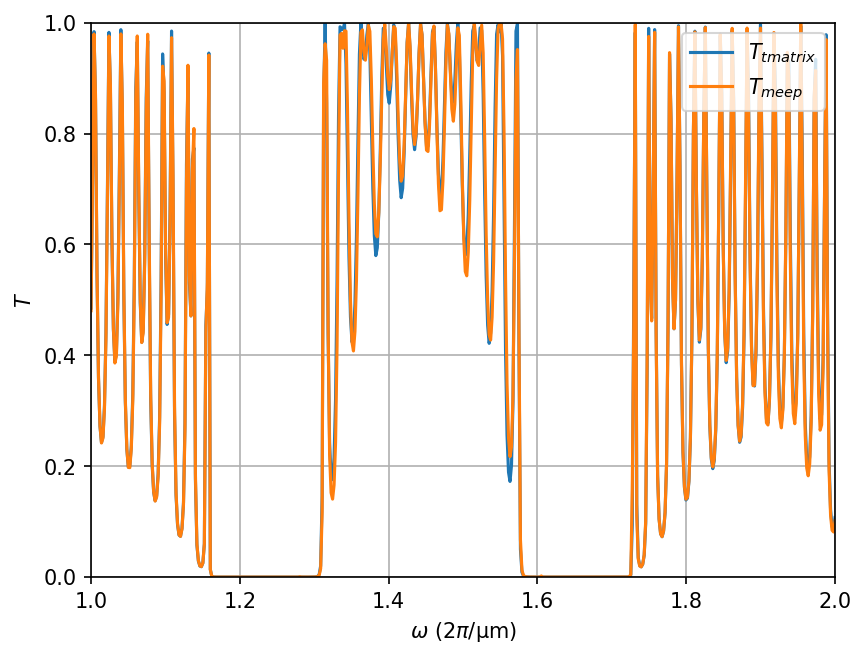

In [19]:
#繪圖比較(數值與實驗)
from matplotlib import pyplot as plt 
plt.figure(dpi=150)
plt.plot(omega/2/np.pi, T_tmat, label='$T_{tmatrix}$')
plt.plot(omega/2/np.pi, T_meep, label='$T_{meep}$')
plt.xlabel("$\omega$ ($2\pi$/μm)")
plt.ylabel("$T$")
plt.legend(loc="upper right")
plt.xlim([1,2])
plt.ylim([0,1])
plt.grid()
plt.show()